# Classify Manhattan with TensorFlow

In this demo, we will use TensorFlow to train a neural network to predict whether a geolocation is in Manhattan or not, by looking at its longitude and latitude.

<br/>
![](images/manhattan.png)
<br/>
<br/>


---
## Importing the training data from BigQuery


In [44]:
%%sql -d standard
SELECT
  timestamp,
  borough,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
ORDER BY
  timestamp DESC
LIMIT
  15

timestamp,borough,latitude,longitude
2017-06-10 23:58:00,,40.603935,-74.18918
2017-06-10 23:55:00,QUEENS,40.73675,-73.87767
2017-06-10 23:50:00,BRONX,40.845238,-73.900894
2017-06-10 23:45:00,,40.757256,-73.98583
2017-06-10 23:40:00,,40.607365,-74.13156
2017-06-10 23:40:00,MANHATTAN,40.757122,-73.987465
2017-06-10 23:40:00,,40.751034,-73.89716
2017-06-10 23:30:00,,40.747574,-73.76147
2017-06-10 23:20:00,MANHATTAN,40.75939,-73.98508
2017-06-10 23:16:00,,40.697582,-73.94965


## Preprocess the training data on BigQuery

In [45]:
%%sql --module nyc_collisions
SELECT
  IF(borough = 'MANHATTAN', 1, 0) AS is_mt,
  latitude,
  longitude
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  LENGTH(borough) > 0
  AND latitude IS NOT NULL AND latitude != 0.0
  AND longitude IS NOT NULL AND longitude != 0.0
  AND borough != 'BRONX'
ORDER BY
  RAND()
LIMIT
  10000

## Import the BigQuery SQL result as NumPy array


In [46]:
import datalab.bigquery as bq
nyc_cols = bq.Query(nyc_collisions).to_dataframe(dialect='standard').as_matrix()

import numpy as np
is_mt = nyc_cols[:,0].astype(np.int32)
latlng = nyc_cols[:,1:3].astype(np.float32)
print("Is Manhattan: " + str(is_mt))
print("\nLat/Lng: \n\n" + str(latlng))
print("\nLoaded " + str(is_mt.size) + " rows.")

Is Manhattan: [0 0 0 ..., 1 0 1]

Lat/Lng: 

[[ 40.59820175 -73.94248199]
 [ 40.69791031 -73.77826691]
 [ 40.66743088 -73.76675415]
 ..., 
 [ 40.74604034 -73.99051666]
 [ 40.66205215 -73.93148041]
 [ 40.75984192 -73.98417664]]

Loaded 10000 rows.


---
## Feature scaling and splitting data

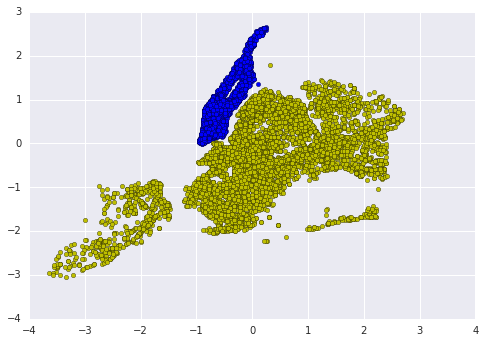

In [47]:
# standardization
from sklearn.preprocessing import StandardScaler
latlng_std = StandardScaler().fit_transform(latlng)

# plotting
import matplotlib.pyplot as plt
lat = latlng_std[:,0]
lng = latlng_std[:,1]
plt.scatter(lng[is_mt == 1], lat[is_mt == 1], c='b') # plot points in Manhattan in blue
plt.scatter(lng[is_mt == 0], lat[is_mt == 0], c='y') # plot points outside Manhattan in yellow
plt.show()

## Split the data into "Training Data" and "Test Data"


In [48]:
# 8,000 pairs for training
latlng_train = latlng_std[0:8000]
is_mt_train = is_mt[0:8000]

# 2,000 pairs for test
latlng_test = latlng_std[8000:10000]
is_mt_test = is_mt[8000:10000]

print("Split finished.")

Split finished.


### Define a single layer neural network

In [49]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR) # supress warning messages

# define two feature columns with real values
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=2)]

# create a neural network
dnnc = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[],
  n_classes=2)

dnnc

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x7f87326d7650>, 'hidden_units': [], 'feature_columns': (_RealValuedColumn(column_name='', dimension=2, default_value=None, dtype=tf.float32, normalizer=None),), 'embedding_lr_multipliers': None, 'optimizer': None, 'dropout': None, 'gradient_clip_norm': None, 'activation_fn': <function relu at 0x7f8761f35c08>, 'input_layer_min_slice_size': None})

## Check the accuracy of the neural network

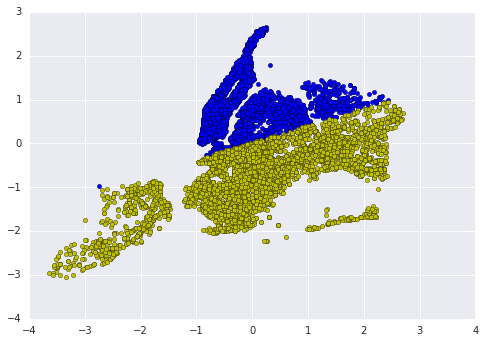

Accuracy: 80.70%


In [50]:
# plot a predicted map of Manhattan
def plot_predicted_map():
  is_mt_pred = dnnc.predict(latlng_std, as_iterable=False) # an array of prediction results
  plt.scatter(lng[is_mt_pred == 1], lat[is_mt_pred == 1], c='b')
  plt.scatter(lng[is_mt_pred == 0], lat[is_mt_pred == 0], c='y')
  plt.show()

# print the accuracy of the neural network 
def print_accuracy():
  accuracy = dnnc.evaluate(x=latlng_test, y=is_mt_test)["accuracy"]
  print('Accuracy: {:.2%}'.format(accuracy))
  
# train the model just for 1 step and print the accuracy
dnnc.fit(x=latlng_train, y=is_mt_train, steps=1)
plot_predicted_map()
print_accuracy()

## Train the neural network

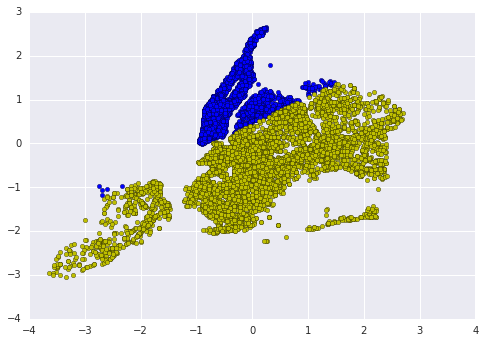

Steps: 100
Accuracy: 93.40%


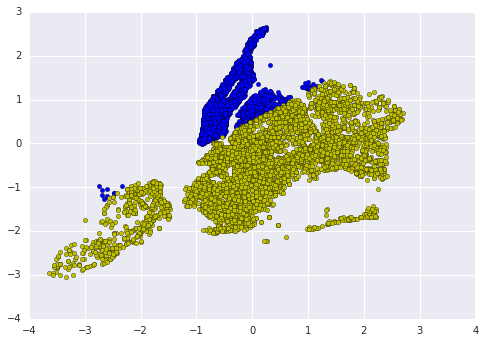

Steps: 200
Accuracy: 94.45%


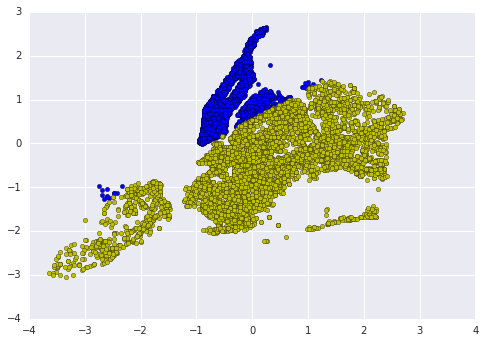

Steps: 300
Accuracy: 95.20%


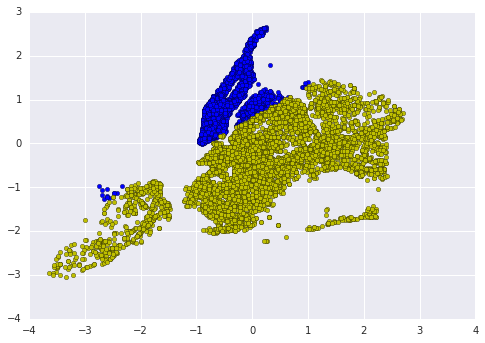

Steps: 400
Accuracy: 95.40%


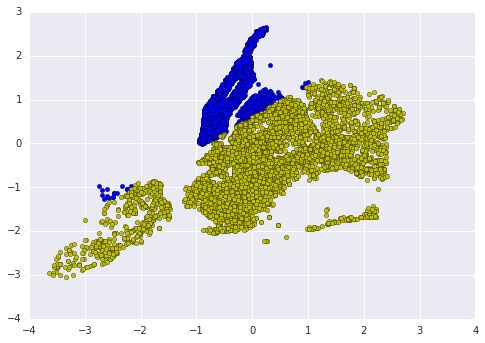

Steps: 500
Accuracy: 95.55%

Training Finished.


In [51]:
steps = 100
for i in range (1, 6):
  dnnc.fit(x=latlng_train, y=is_mt_train, steps=steps)
  plot_predicted_map()
  print('Steps: ' + str(i * steps))
  print_accuracy()
  
print('\nTraining Finished.')

---
## Train a Deep Neural Network with TensorFlow


In [52]:
dnnc = tf.contrib.learn.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20, 20, 20, 20],
  n_classes=2)
dnnc

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x7f8731cb2d50>, 'hidden_units': [20, 20, 20, 20], 'feature_columns': (_RealValuedColumn(column_name='', dimension=2, default_value=None, dtype=tf.float32, normalizer=None),), 'embedding_lr_multipliers': None, 'optimizer': None, 'dropout': None, 'gradient_clip_norm': None, 'activation_fn': <function relu at 0x7f8761f35c08>, 'input_layer_min_slice_size': None})

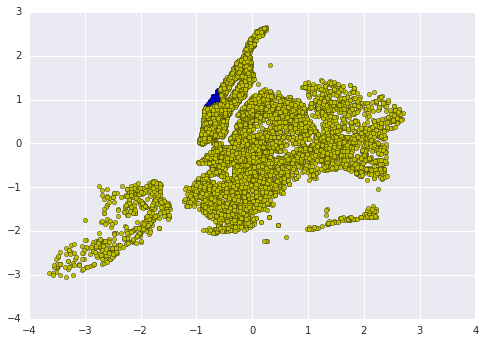

Steps: 30
Accuracy: 72.75%


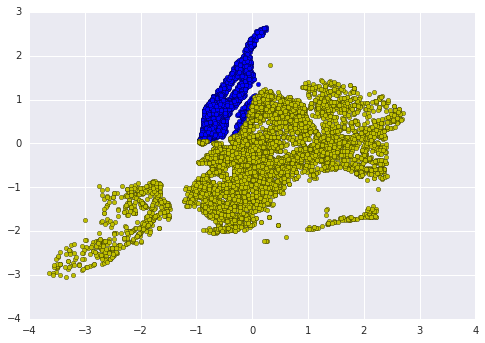

Steps: 60
Accuracy: 98.05%


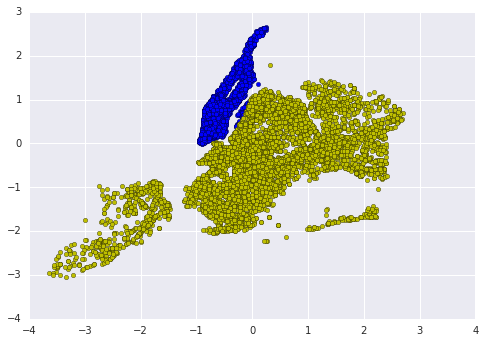

Steps: 90
Accuracy: 99.35%


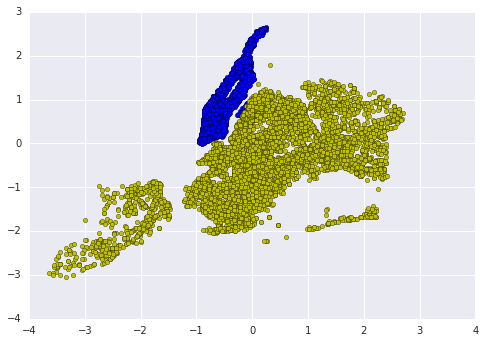

Steps: 120
Accuracy: 99.80%


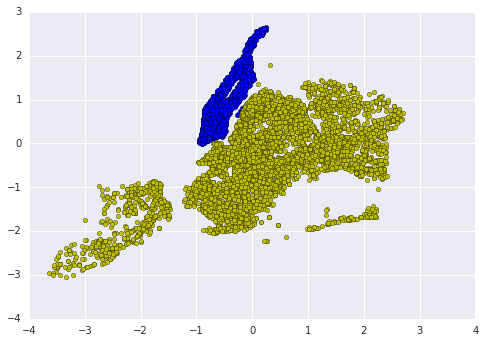

Steps: 150
Accuracy: 99.90%

Training Finished.


In [53]:
steps = 30
for i in range (1, 6):
  dnnc.fit(x=latlng_train, y=is_mt_train, steps=steps)
  plot_predicted_map()
  print 'Steps: ' + str(i * steps)
  print_accuracy()
  
print('\nTraining Finished.')